In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [23]:
def metropolis_step(N, grid, J, beta=1.0):
    i, j = np.random.randint(0, N, 2)
    current_angle = grid[i, j]
    new_angle = 2*np.pi*np.random.rand()

    # Calculate energy change
    delta_E = 0
    delta_E -= J[i,j,0]*np.cos(new_angle-grid[(i + 1) % N, j])-np.cos(current_angle-grid[(i + 1) % N, j])
    delta_E -= J[i-1,j,0]*np.cos(new_angle-grid[(i - 1) % N, j])-np.cos(current_angle-grid[(i - 1) % N, j])
    delta_E -= J[i,j,1]*np.cos(new_angle-grid[i, (j + 1) % N])-np.cos(current_angle-grid[i, (j + 1) % N])
    delta_E -= J[i-1,j,1]*np.cos(new_angle-grid[i, (j - 1) % N])-np.cos(current_angle-grid[i, (j - 1) % N])

    # Metropolis criterion
    if delta_E < 0 or np.random.rand() < np.exp(-delta_E*beta):
        grid[i, j] = new_angle

    return grid


In [24]:
def plot_grid_orientations(grid, step, beta, filename_pattern):
    N = grid.shape[0]
    X, Y = np.meshgrid(range(N), range(N))
    U = np.cos(grid)
    V = np.sin(grid)

    plt.figure(figsize=(8, 8))
    plt.quiver(X, Y, U, V, pivot='middle')
    plt.title(f"Temperature {1/beta} Step {step}")
    plt.savefig(filename_pattern.format(beta, step))  # Save the plot as an image
    plt.close()  # Close the plot to free memory

In [39]:
# Modify your simulation loop to save images
image_folder = 'simulation_frames'
os.makedirs(image_folder, exist_ok=True)
filename_pattern = os.path.join(image_folder, 'frame_{:02f}_{:04d}.png')

In [40]:
n = 5 #num of different J
N = 64  # Grid size
steps = 5000  # Number of simulation steps
m = 100 #num of thermalization
betas = [0.01, 0.1, 1, 10, 100, 1000]
history = np.zeros((n, len(betas), steps+1, N, N), dtype='float32')
ods = np.zeros((n,len(betas), steps-m))
some_interval = 100



for k in range(n):
    #Initialize spin orientation.
    grid = 2*np.pi*np.random.rand(N, N)
    
    #Initialize spin-spin interaction coefficient.
    random_array = np.random.rand(N, N, 2)
    J = np.where(random_array < 0.5, -1, 1)

    for l in range(len(betas)):
        beta = betas[l]
        for h in range(steps):
            grid = metropolis_step(N, grid, J, beta)
            history[k, l, h, ...] = grid
            if h>m-1:
                ods[k,l,h-m] = np.mean(np.cos(grid))

            # Plotting at selected steps
            if h % some_interval == 0 and k == 0:  # 'some_interval' is the frequency of steps at which you want to plot
                plot_grid_orientations(grid, h, beta, filename_pattern)

    if k==0:
        break


In [36]:
# After simulation, create a video
video_name = 'simulation_video.mp4'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 24, (width, height))

for image in sorted(images):
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

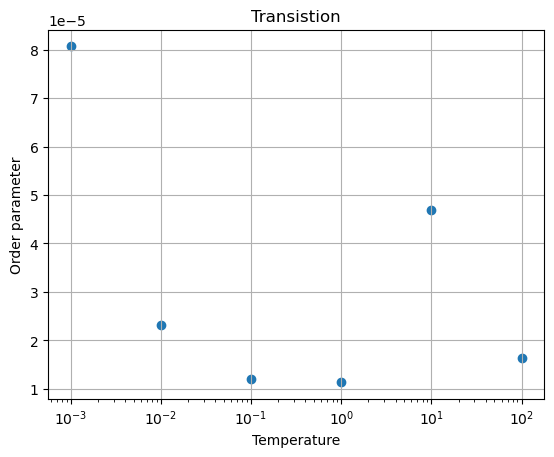

In [42]:
odt = np.mean(ods, axis=2)**2
odt = np.mean(odt, axis=0)
# Plotting the results
#plt.figure(figsize=(10, 6))
temperatures = [1/t for t in betas]
plt.scatter(temperatures, odt)
plt.xscale('log')
plt.xlabel('Temperature')
plt.ylabel('Order parameter')
plt.title('Transistion')
plt.grid(True)
plt.show()

In [48]:
def angle_correlation_function(N, grids, distance):
    total_cos = 0
    count = 0

    # Loop over the entire grid
    for s in range(grids.shape[0]):
        for i in range(N):
            for j in range(N):
                # Neighbors at distance 'distance'
                neighbors = [
                    ((i + distance) % N, j),  # right
                    ((i - distance) % N, j),  # left
                    (i, (j + distance) % N),  # up
                    (i, (j - distance) % N)   # down
                ]

                for (ni, nj) in neighbors:
                    total_cos += np.cos(grids[s, i, j] - grids[s, ni, nj])
                    count += 1

    return total_cos / count if count else 0

ful_correlations = np.zeros((n, len(betas), N-1))
distances = range(1, N)
for i in range(n):
    for j in range(len(betas)):
        grids = history[i,j]
        correlations = [angle_correlation_function(N, grids, distance) for distance in distances]
        ful_correlations[i,j,...] = correlations


KeyboardInterrupt: 

In [ ]:
for k in range(len(betas)):
    plt.plot(distance, ful_correlations[0,k])
plt.xlabel('distance')
plt.ylabel('Correlation')
plt.title('Transistion')
plt.grid(True)
plt.show()

In [ ]:
, marker='o'
序参数
可视化
不同的cooling rate  32-2048
1.直接到T
2.低温下cooling rate